## 19.1 자바스크립트 함수 비동기 로딩
- 일반 자바스크립트 함수 스플리팅 
    ```js
    export default function notify() {
        alert("안녕하세요!");
    }
    ```
- app 컴포넌트 수정
    ```js
    import React from "react";
    import logo from "./logo.svg";
    import "./App.css";
    import notify from "./notify";

    function App() {
    const onClick = () => {
        notify();
    };
    return (
        <div className="App">
        <header className="App-header">
            <img src={logo} className="App-logo" alt="logo" />
            <p onClick={onClick}>Hello React!</p>
        </header>
        </div>
    );
    }

    export default App;
    ```
    - 빌드 시 notify 코드가 main 파일에 들어감
    - 수정
        ```js
        import React from "react";
        import logo from "./logo.svg";
        import "./App.css";

        function App() {
        const onClick = () => {
            import("./notify").then((result) => result.default());
        };
        return (
            <div className="App">
            <header className="App-header">
                <img src={logo} className="App-logo" alt="logo" />
                <p onClick={onClick}>Hello React!</p>
            </header>
            </div>
        );
        }

        export default App;
        ```
    - Hello React!를 클릭하는 시점에서 notify 불러온다
    - 빌드시 새로 시작하는 숫자 파일 안에 notify 관련 코드가 들어가게 된다(스플리팅)

## 19.2 React.lazy와 Suspense를 통한 컴포넌트 코드 스플리팅
- React.lazy 
    - 컴포넌트를 렌더링하는 시점에서 비동기적으로 로딩할 수 있게 해주는 유틸 함수
- Suspense 
    - 리액트 내장 컴포넌트, 코드 스플리팅 된 컴포넌트를 로딩하도록 발동시킬 수 있다
    - 로딩이 끝나지 않았을 때 보여 줄 UI를 설정할 수 있다

### 1. state를 사용한 코드 스플리팅
- React.lazy를 사용하지 않고 코드 스플리팅
    ```js
    import React from "react";

    const SplitMe = () => {
        return <div>SplitMe</div>;
    };

    export default SplitMe;
    ```
- app 컴포넌트를 클래스형 컴포넌트로 전환
    - handleClick 메서드를 만들고, 내부에서 SplitMe 컴포넌트를 불러와 state에 넣음
    - render 함수에서는 state안에 있는 SplitMe가 유요하다면 SplitMe 컴포넌트를 렌더링
        ```js
        import React, { Component } from "react";
        import logo from "./logo.svg";
        import "./App.css";

        class App extends Component {
        state = {
            SplitMe: null,
        };
        handleClick = async () => {
            const loadedModule = await import("./SplitMe");
            this.setState({
            SplitMe: loadedModule.default,
            });
        };
        render() {
            const { SplitMe } = this.state;
            return (
            <div className="App">
                <header className="App-header">
                <img src={logo} className="App-logo" alt="logo" />
                <p onClick={this.handleClick}>Hello React!</p>
                {SplitMe && <SplitMe />}
                </header>
            </div>
            );
        }
        }

        export default App;
        ```
        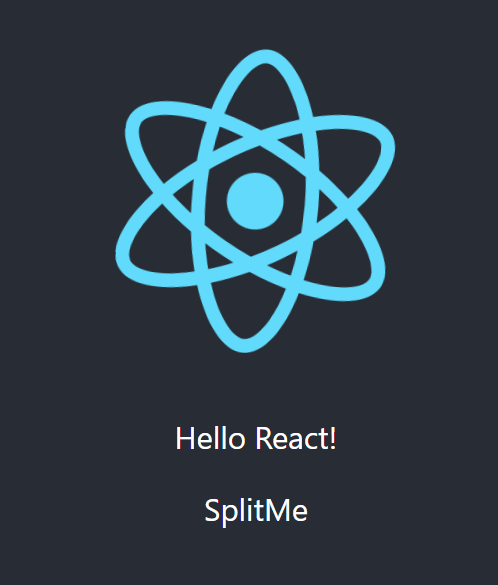

### 2. React.lazy와 Suspense 사용하기
- React.lazy와 Suspense를 사용하면 코드 스플리팅을 위한 state를 따로 선언하지 않아도 된다
- React.lazy 컴포넌트 사용법
    ```js
    const SplitMe = React.lazy(() => import('./SplitMe'));
    ```
- Suspense 사용법
    ```js
    import React, { Suspense } from 'react';

    (...)
    <Suspense fallback={<div>loading...</div>}>
    <SplitMe />
    </Suspense>
    ```
- App 컴포넌트에 적용
    - 함수 컴포넌트로 전환
        ```js
        import React, { useState, Suspense } from 'react';
        import logo from './logo.svg';
        import './App.css';

        const SplitMe = React.lazy(() => import('./SplitMe'));

        function App() {
        const [visible, setVisible] = useState(false);
        const onClick = () => {
            setVisible(true);
        };
        return (
            <div className="App">
            <header className="App-header">
                <img src={logo} className="App-logo" alt="logo" />
                <p onClick={onClick}>Hello React!</p>
                <Suspense fallback={<div>loading…</div>}>
                {visible && <SplitMe />}
                </Suspense>
            </header>
            </div>
        );
        }

        export default App;
        ```
        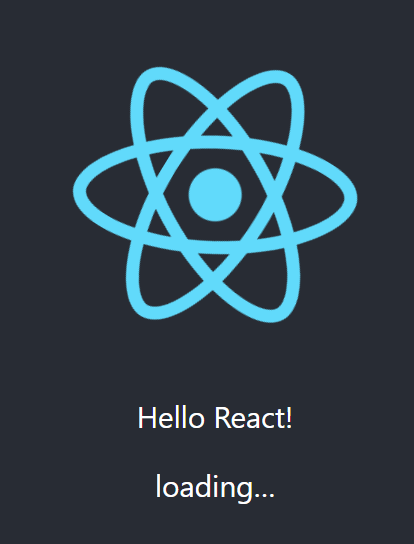

### 3. Loadable Components를 통한 코드 스플리팅
- Loadable Components 
    - 코드 스플리팅을 편하게 하도록 도와주는 서드파티 라이브러리
- React.lazy와 Suspense는 서버 사이드 렌더링을 지원하지 않지만, Loadable Components 은 서버 사이드 렌더링을 지원

- 서버 사이드 렌더링
    - 웹 서비스의 초기 로딩 속도 개선, 캐싱 및 검색 엔진 최적화를 가능하게 해주는 기술 서버 사이드 렌더링을 사용하면 웹 서비스의 초기 렌더링을 사용자 브라우저가 아닌 서버에서 처리함.
- yarn add @loadable/component

- 적용
    ```js
    import React, { useState } from 'react';
    import logo from './logo.svg';
    import './App.css';
    import loadable from '@loadable/component';

    const SplitMe = loadable(() => import('./SplitMe'));

    function App() {
    const [visible, setVisible] = useState(false);
    const onClick = () => {
        setVisible(true);
    };
    return (
        <div className="App">
        <header className="App-header">
            <img src={logo} className="App-logo" alt="logo" />
            <p onClick={onClick}>Hello React!</p>
            {visible && <SplitMe />}
        </header>
        </div>
    );
    }

    export default App;
    ```
    - 만약, 로딩 중 다른 UI를 보여 주고 싶다면, loadable를 사용하는 부분을 수정한다.
        ```js
        const SplitMe = loadable(() => import('./SplitMe'), {
        fallback: <div>loading…</div>
        });
        ```
- preload 
    - 컴포넌트를 미리 불러오는 방법
    - 마우스 커서를 Hello React에 올리기만 해도 로딩이 시작됨, 클릭 했을 때 렌더링 
        ```js
        import React, { useState } from "react";
        import logo from "./logo.svg";
        import "./App.css";
        import loadable from "@loadable/component";

        const SplitMe = loadable(() => import("./SplitMe"));

        function App() {
        const [visible, setVisible] = useState(false);
        const onClick = () => {
            setVisible(true);
        };
        const onMouseOver = () => {
            SplitMe.preload();
        };
        return (
            <div className="App">
            <header className="App-header">
                <img src={logo} className="App-logo" alt="logo" />
                <p onClick={onClick} onMouseOver={onMouseOver}>
                Hello React!
                </p>
                {visible && <SplitMe />}
            </header>
            </div>
        );
        }

        export default App;
        ```
- 더 다양한 loadable-components
    - https://loadable-components.com/docs/delay/

## 19.3 정리
- 코드 스플리팅이 무엇인지, 컴포넌트를 어떻게 분리된 파일로 저장하고, 비동기적으로 불러와서 사용하는지 학습
- 서버 사이드 렌더링을 할 계획이 없다면 React.lazy와 Suspense로 구현
- 계획이 있다면 Loadable Components 라이브러리 사용
- React.lazy : 컴포넌트를 렌더링하는 시점에서 비동기적으로 로딩할 수 있게 해 주는 유틸 함수
- Suspense : 리액트 내장 컴포넌트로 코드 스플리팅 된 컴포넌트를 로딩하도록 발동시킬 수 있는 함수